In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import scipy.misc
import glob
from matplotlib.patches import Polygon

In [2]:
def getCameraCallibrationResults(img, nx = 9, ny = 6):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    objPoints = []
    imgPoints = []
    
    objPointsDetected = np.zeros((nx * ny, 3), np.float32)
    objPointsDetected[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret == True:
        objPoints.append(objPointsDetected)
        imgPoints.append(corners)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, gray.shape[::-1], None, None)
        return  ret, mtx, dist, rvecs, tvecs
    else:
        return (None,None,None,None,None)

Text(0.5,1,'Undistorted Image')

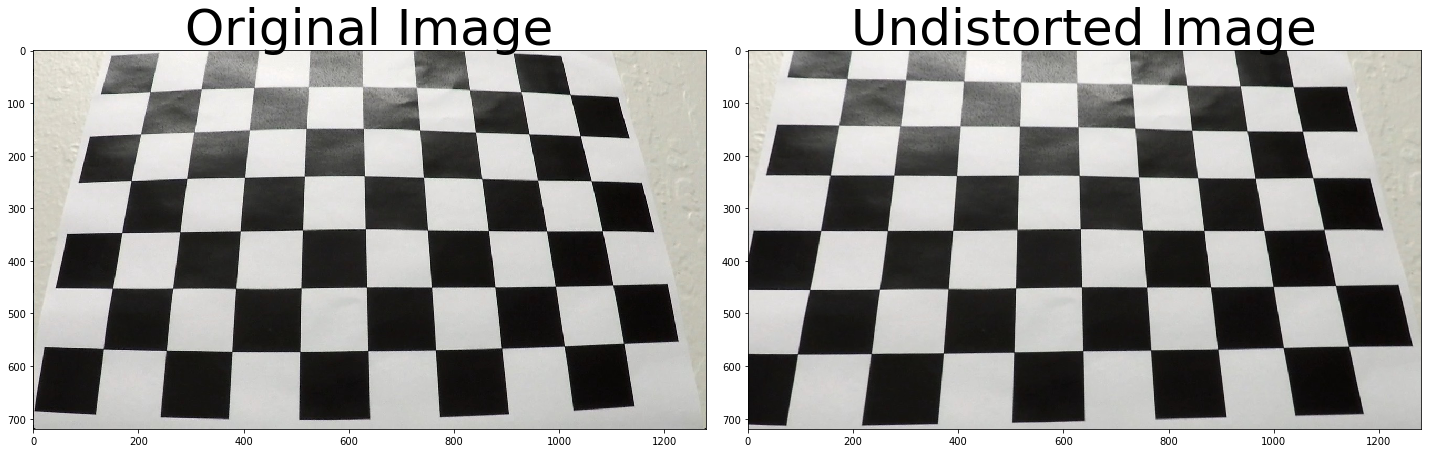

In [3]:
path = "camera_cal/calibration3.jpg"
# outputPath = "output_images/"
chessImage = mpimg.imread(path)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(chessImage)
ax1.set_title('Original Image', fontsize=50)
ret, cameraMatrix, distortionCoefficients, rvecs, tvecs = getCameraCallibrationResults(chessImage)
undistort = cv2.undistort(chessImage, cameraMatrix, distortionCoefficients, None, cameraMatrix)
ax2.imshow(undistort)
ax2.set_title('Undistorted Image', fontsize=50)
# cv2.imwrite(os.path.join(outputPath ,"undistortedImageOfChessBoard"), undistort)

In [4]:
def abs_sobel_thresh(img, orient, sobel_kernel=3, thresh = (0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = []
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    absoluteValue = np.absolute(sobel)
    scaledSobel = np.uint8(255*absoluteValue/np.max(absoluteValue))
    sbinary = np.zeros_like(scaledSobel)
    sbinary[(scaledSobel > thresh[0]) & (scaledSobel < thresh[1])] = 1
    return sbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    absoluteValue = np.sqrt(sobelX**2 + sobelY**2)
    scale_factor = np.max(absoluteValue)/255 
    scaledSobel = (absoluteValue/scale_factor).astype(np.uint8)
    sBinary = np.zeros_like(scaledSobel)
    sBinary[(scaledSobel > mag_thresh[0]) & (scaledSobel < mag_thresh[1])] = 1
    return sBinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobelY), np.absolute(sobelX))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1]) & (l_channel > 100)] = 1
    return binary_output

def gradientAndColorThreshold(img):
    ksize = 3
    
    image = np.copy(img)
    
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(0, 255))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.2))
    hls_binary = hls_select(image, thresh=(90, 255))
    
    combined = np.zeros_like(dir_binary)
    combined[(gradx == 1) & (grady == 1)| (hls_binary == 1)] = 1
    return combined

In [5]:
def perspectiveTransform(img):
#     src = np.float32([[609, 437], [669, 437], [351, 621], [954, 621]])
#     dst = np.float32([[300, 0], [1000, 0], [300, 720], [1000, 720]])
    src = np.float32([[600,460],[740,460],[1100,700],[250,700]])
    dst = np.float32([[300,0],[1000,0],[1000,720],[300,720]])
    ax1.plot(Polygon(src).get_xy()[:, 0], Polygon(src).get_xy()[:, 1], color='red')
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped, Minv

In [6]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [7]:
def findLaneBoundary(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    
    out_img = np.dstack((img, img, img))*255
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    margin = 100
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) 
        & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) 
        & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean((nonzerox[good_left_inds])))
        
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean((nonzerox[good_right_inds])))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = findLaneBoundary(binary_warped)
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx =1*ploty**2 + 1*ploty
        
    return out_img, left_fit, right_fit, ploty, left_fitx, right_fitx, left_fit_cr, right_fit_cr

In [8]:
def measureRadiusOfCurvature(left_fit_cr, right_fit_cr, img):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = img.shape[0]
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [9]:
def calculateDistanceOfCarFromCentre(left_fit, right_fit,img):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = img.shape[0]
    
    left_lane_bottom = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_lane_bottom = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    lane_center = left_lane_bottom + (right_lane_bottom - left_lane_bottom) / 2 
    
    pixelDistance = img.shape[1]/2 - lane_center
#     print(img.shape[1]/2, lane_center, pixelDistance)
    realDistance = pixelDistance*xm_per_pix
    return str(abs(round(realDistance,3)))

In [10]:
def unwarp(warped, left_fitx, right_fitx, ploty, Minv, image):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

In [11]:
def pipeline(img):
    gradientImage = gradientAndColorThreshold(img)
    warped, Minv = perspectiveTransform(gradientImage)
    copywarped = np.copy(warped)
    x, left_fit, right_fit, ploty, left_fitx, right_fitx, left_fit_cr, right_fit_cr = fit_polynomial(copywarped)
    left_curverad, right_curverad = measureRadiusOfCurvature(left_fit_cr, right_fit_cr, img)
    distance = calculateDistanceOfCarFromCentre(left_fit, right_fit,img)
    result = unwarp(warped, left_fitx, right_fitx, ploty, Minv, img)
    caption = "Radius of Curve = " + str((left_curverad + right_curverad)/2) + "m and Distance = " + distance + "m"
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, caption, (200, 50), font, 1, (255, 255, 255), 3) 
    return x, gradientImage, warped, result, left_fitx, right_fitx, ploty, left_curverad, right_curverad

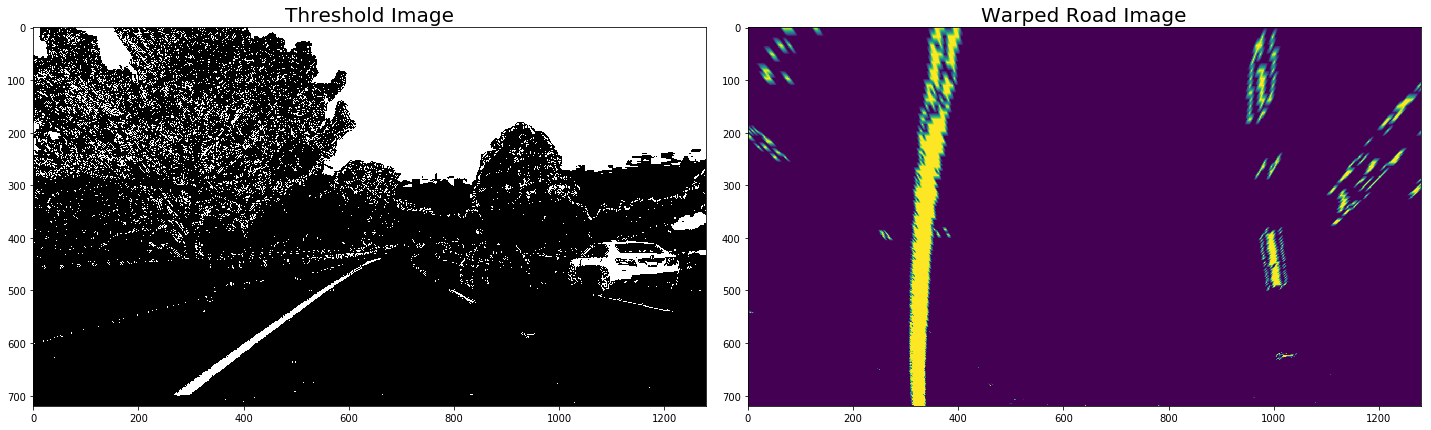

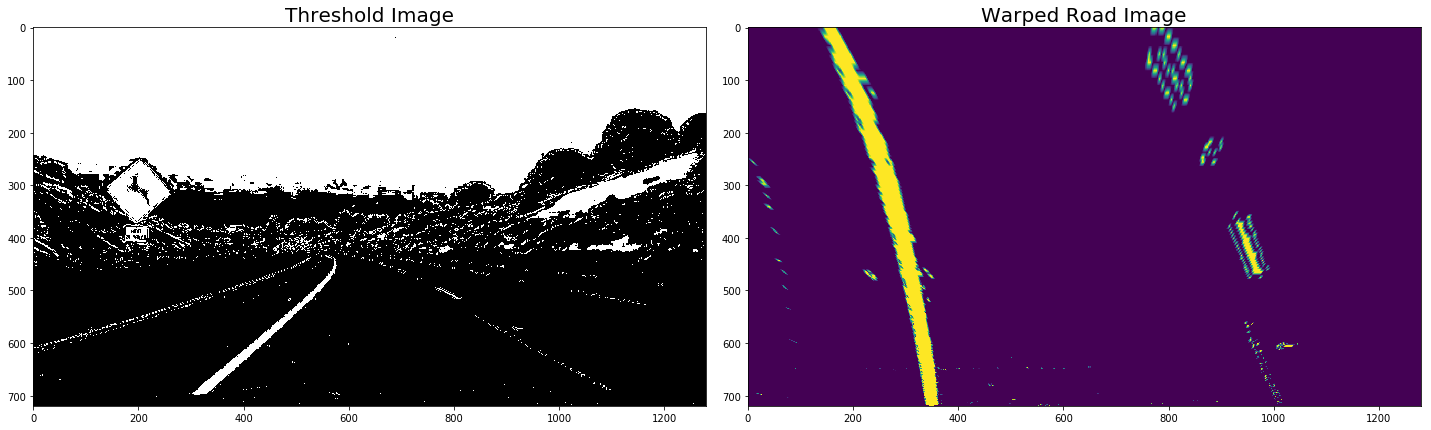

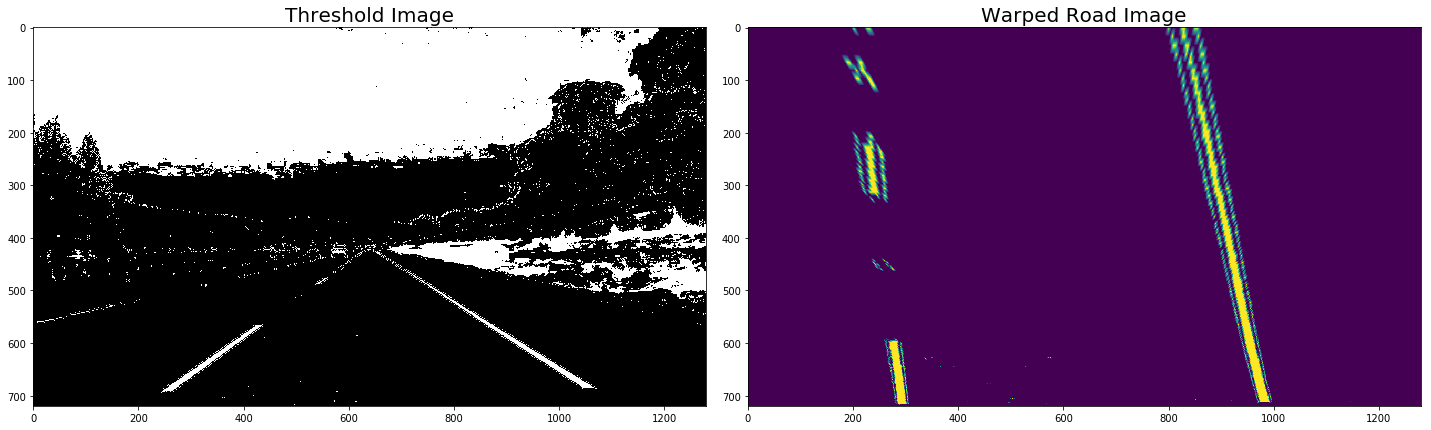

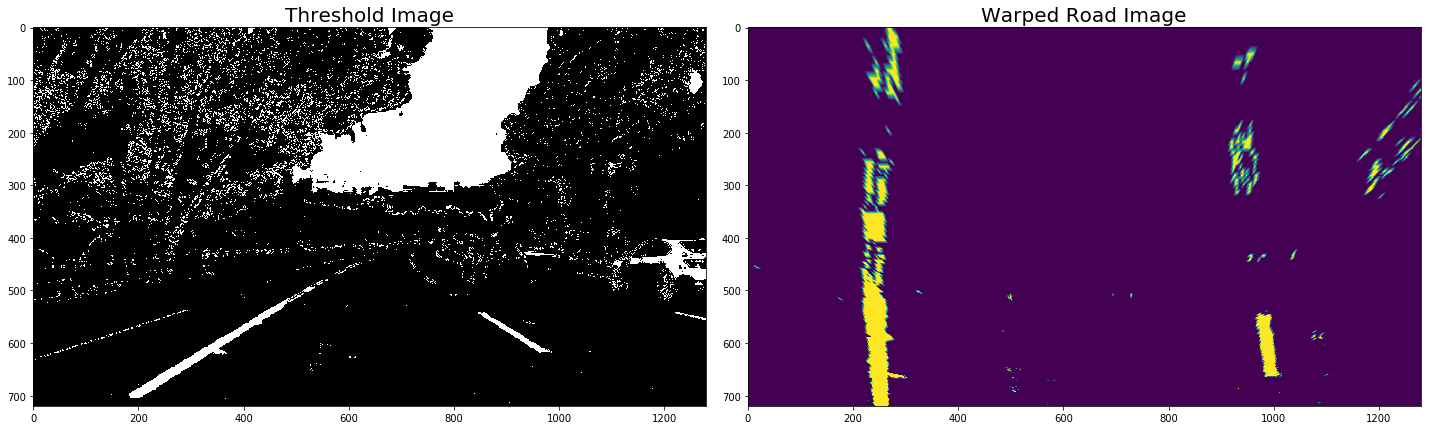

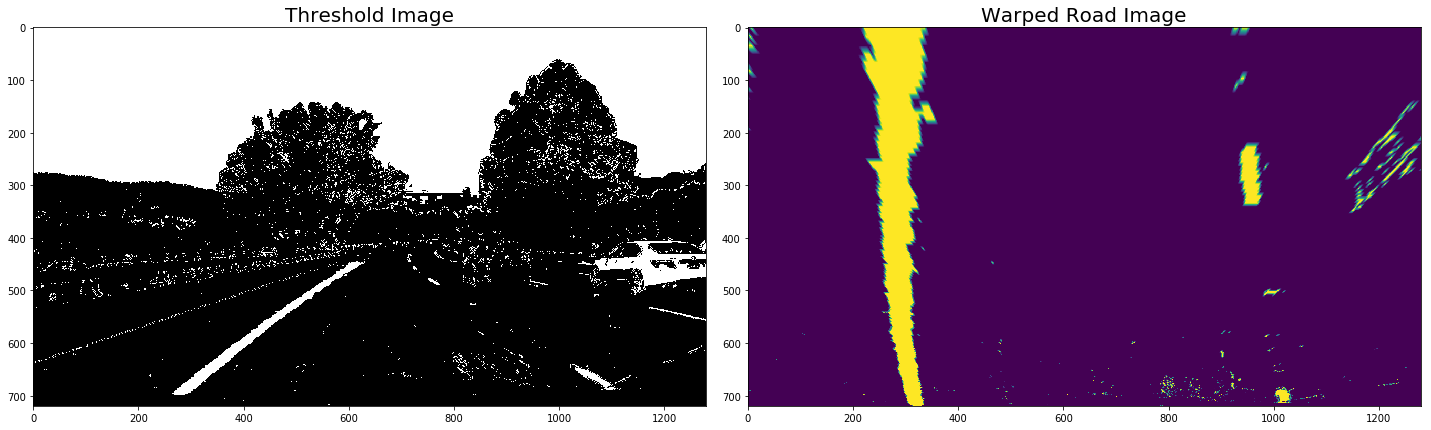

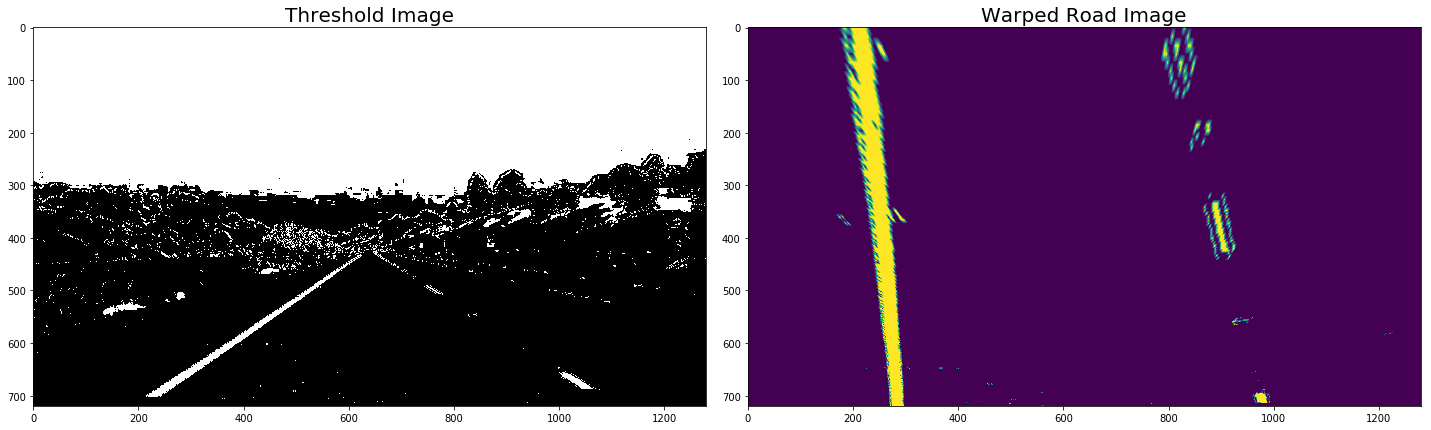

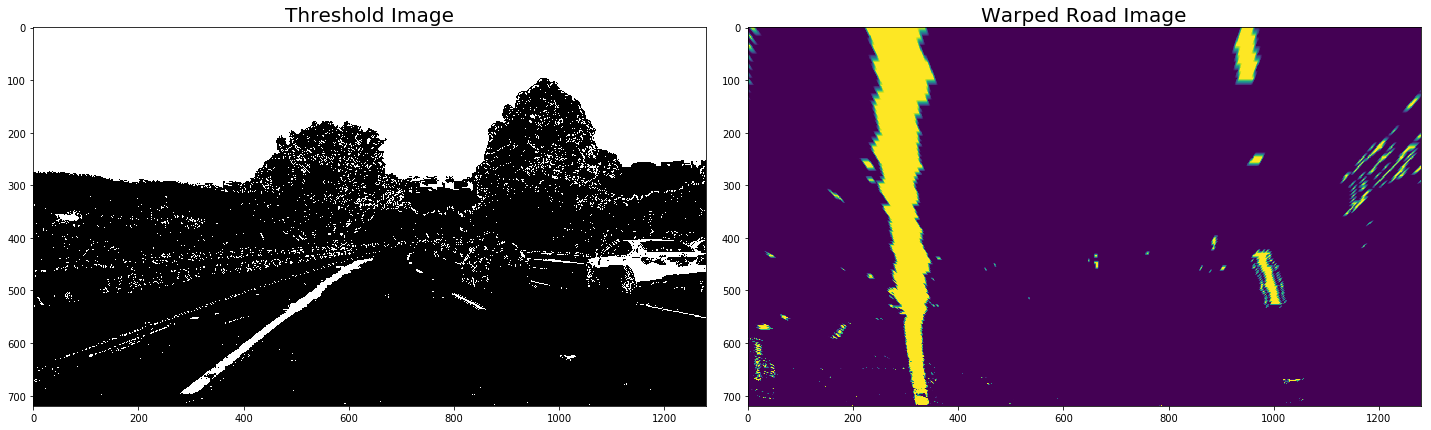

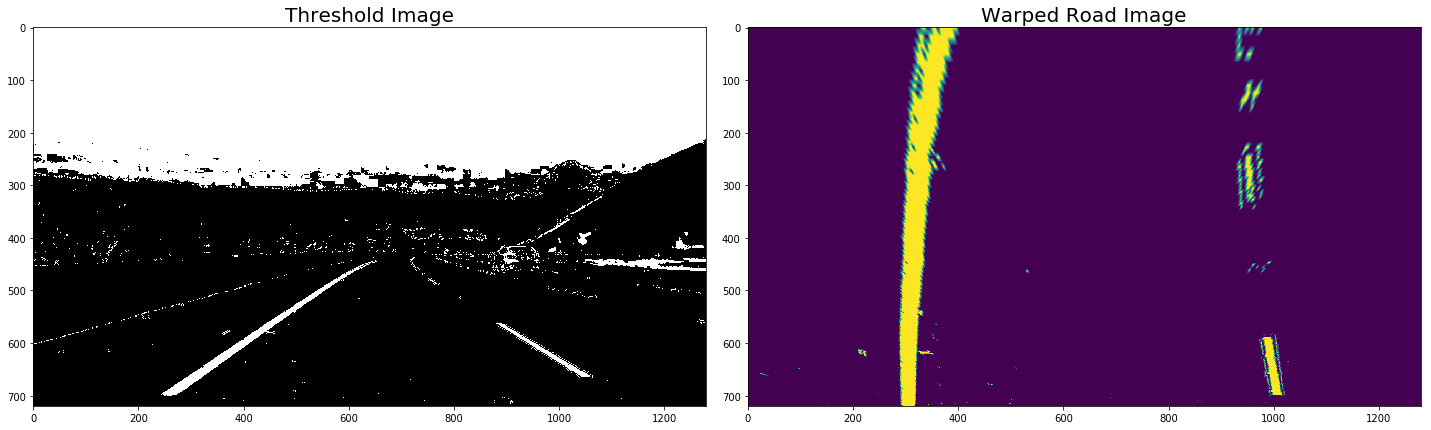

In [12]:
path = "test_images/"
outputPath = "output_images/"
testImageStrings = os.listdir(path)
for testImageString in testImageStrings:
    testImage = mpimg.imread(path + testImageString)
    undistortedTestImage = cv2.undistort(testImage, cameraMatrix, distortionCoefficients, None, cameraMatrix)
#     f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 10))
    f, (ax2, ax3) = plt.subplots(1, 2, figsize=(20, 10))
    f.tight_layout()
#     ax1.imshow(testImage)
#     ax1.set_title('Original Image', fontsize=20)
    fittedLines, gradient, warped, result, left_fitx, right_fitx, ploty, left_curverad, right_curverad = pipeline(undistortedTestImage)
    ax2.imshow(gradient, cmap='gray')
    ax2.set_title('Threshold Image', fontsize=20)
    ax3.imshow(warped)
    ax3.set_title('Warped Road Image', fontsize=20)
#     ax4.plot(left_fitx, ploty, color='yellow')
#     ax4.plot(right_fitx, ploty, color='yellow')
#     ax4.imshow(fittedLines)
#     ax4.set_title('Lane Line Detected on Warped Image', fontsize=20)
#     ax5.imshow(result)
#     ax5.set_title('Unwarped Road Image', fontsize=20)
#     cv2.imwrite(os.path.join(outputPath , "undistortedImageOf" + testImageString), undistortedTestImage)
#     cv2.imwrite(os.path.join(outputPath , "gradientImageOf" + testImageString), gradient)
#     cv2.imwrite(os.path.join(outputPath , "warpedImageOf" + testImageString), warped)
#     cv2.imwrite(os.path.join(outputPath , "linesFittedImageOf"+ testImageString), fittedLines)
#     cv2.imwrite(os.path.join(outputPath , "resultOf" + testImageString), result)

In [13]:
# Import everything needed to edit/save/watch video clips
!pip install imageio-ffmpeg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

  Running setup.py bdist_wheel for imageio-ffmpeg ... done
  Stored in directory: /root/.cache/pip/wheels/54/ed/2d/4281f5e6a575bfaa7d8f1f4173a7cb635adc406c1f8d87bfc8
Successfully built imageio-ffmpeg


In [14]:
def process_image(image):
    fittedLines, gradient, warped, result, left_fitx, right_fitx, ploty, left_curverad, right_curverad = pipeline(image)
    return result

In [15]:
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [06:17<00:00,  3.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 4min 6s, sys: 3.17 s, total: 4min 9s
Wall time: 6min 20s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))